# Analysis accomodation in Montreal

I will analyse a dataset on the Airbnb platform about the accomodation in Montreal city. <br>
https://insideairbnb.com/get-the-data

## Datasets:

- `listings.csv.gz` - Detailed listings
- `calendar.csv.gz` - Detailed calendar
- `reviews.csv.gz` - Detailed reviews
- `listings.csv` - Summary listings
- `reviews.csv` - Summary reviews
- `neighbourhoods.csv` - Neighbourhood list
- `neighbourhoods.geojson` - GeoJson file of neighbourhoods

## Libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap
from folium.plugins import HeatMap

# plotly graphs
import plotly.graph_objs as go
import plotly_express as px
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# AB testing
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import mannwhitneyu
from scipy.stats import skew
from scipy.stats import f_oneway
from pycaret.regression import *

from scipy import stats

import mpld3

## Reading the datasets

In [2]:
listings = pd.read_csv('https://data.insideairbnb.com/canada/qc/montreal/2024-03-23/data/listings.csv.gz', index_col= "id", low_memory=False)
reviews = pd.read_csv('https://data.insideairbnb.com/canada/qc/montreal/2024-03-23/data/reviews.csv.gz', parse_dates=['date'], index_col=['listing_id'])
calendar = pd.read_csv('https://data.insideairbnb.com/canada/qc/montreal/2024-03-23/data/calendar.csv.gz', parse_dates=['date'], index_col=['listing_id'])
neighbourhoods = pd.read_csv('https://data.insideairbnb.com/canada/qc/montreal/2024-03-23/visualisations/neighbourhoods.csv')
neighbourhoods_geojson = gpd.read_file("https://data.insideairbnb.com/canada/qc/montreal/2024-03-23/visualisations/neighbourhoods.geojson")

#listings_summary = pd.read_csv('https://data.insideairbnb.com/canada/qc/montreal/2024-03-23/visualisations/listings.csv', index_col= "id", low_memory=False) 
# reviews_summary = pd.read_csv('https://data.insideairbnb.com/canada/qc/montreal/2024-03-23/visualisations/reviews.csv', parse_dates=['date'], index_col=['listing_id'])

In [3]:
print('Listings shape:', listings.shape)
print('Calendar shape:',calendar.shape)
print('Reviews shape:',reviews.shape)
print('Neighbourhood shape:',neighbourhoods.shape)

Listings shape: (8140, 74)
Calendar shape: (2971100, 6)
Reviews shape: (302513, 5)
Neighbourhood shape: (34, 2)


In [4]:
# Code to show all columns of the datasets
pd.set_option('display.max_columns', None)

In [5]:
listings.head(2)

,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29059,https://www.airbnb.com/rooms/29059,20240323015116,2024-03-23,city scrape,Lovely studio Quartier Latin,CITQ 267153<br />Lovely studio with 1 closed r...,NaN,https://a0.muscache.com/pictures/736399/fa6c31...,125031,https://www.airbnb.com/users/show/125031,Maryline,2010-05-14,"Montreal, Canada",Voyageuse dans l'âme j'aime parcourir le monde...,within an hour,100%,98%,f,https://a0.muscache.com/im/pictures/user/8c35f...,https://a0.muscache.com/im/pictures/user/8c35f...,Downtown Montreal,2,2,"['phone', 'work_email']",t,t,NaN,Ville-Marie,NaN,45.51939,-73.56482,Entire rental unit,Entire home/apt,4,1.0,1 bath,1.0,3.0,"[""Books and reading material"", ""Paid parking l...",$164.00,2,60,2,2,1125,1125,2.0,1125.0,NaN,t,23,53,76,302,2024-03-23,450,48,3,2010-06-20,2024-03-16,4.67,4.79,4.62,4.81,4.77,4.82,4.68,"267153, expires: 2024-03-31",f,2,2,0,0,2.69
29061,https://www.airbnb.com/rooms/29061,20240323015116,2024-03-23,city scrape,Maison historique - Quartier Latin,Lovely historic house with plenty of period ch...,NaN,https://a0.muscache.com/pictures/9e59d417-4b6a...,125031,https://www.airbnb.com/users/show/125031,Maryline,2010-05-14,"Montreal, Canada",Voyageuse dans l'âme j'aime parcourir le monde...,within an hour,100%,98%,f,https://a0.muscache.com/im/pictures/user/8c35f...,https://a0.muscache.com/im/pictures/user/8c35f...,Downtown Montreal,2,2,"['phone', 'work_email']",t,t,NaN,Ville-Marie,NaN,45.51929,-73.56493,Entire home,Entire home/apt,4,1.0,1 bath,2.0,2.0,"[""Books and reading material"", ""Coffee maker: ...",$349.00,2,21,2,2,21,21,2.0,21.0,NaN,t,24,54,78,348,2024-03-23,130,19,0,2012-02-23,2024-02-19,4.73,4.85,4.66,4.88,4.81,4.87,4.73,"267153, expires: 2024-03-31",f,2,2,0,0,0.88


In [6]:
listings['host_is_superhost'] = listings['host_is_superhost'].replace({'t': True, 'f': False})
listings['host_has_profile_pic'] = listings['host_has_profile_pic'].replace({'t': True, 'f': False})

In [7]:
calendar.head(2)

,date,available,price,adjusted_price,minimum_nights,maximum_nights
listing_id,,,,,,
29059,2024-03-23,f,$159.00,NaN,2,1125
29059,2024-03-24,f,$159.00,NaN,2,1125


In [8]:
calendar['available'] = calendar['available'].replace({'t': True, 'f': False})

In [9]:
reviews.head(2)

,id,date,reviewer_id,reviewer_name,comments
listing_id,,,,,
29059,55332,2010-06-20,116906,Yvette,This apt was soooo adorable! Centrally located...
29059,59988,2010-07-02,116980,Alejandro,I had a wonderful stay at Maryline's lovely an...


In [10]:
neighbourhoods.head(2)

,neighbourhood_group,neighbourhood
0,NaN,Ahuntsic-Cartierville
1,NaN,Anjou


## Pre-processing: Repair columns, treatment of nulls and outliers

### Information

In [11]:
# First I check the type of data I have
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 29059 to 1118138226258202248
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   8140 non-null   object 
 1   scrape_id                                     8140 non-null   int64  
 2   last_scraped                                  8140 non-null   object 
 3   source                                        8140 non-null   object 
 4   name                                          8140 non-null   object 
 5   description                                   7986 non-null   object 
 6   neighborhood_overview                         4211 non-null   object 
 7   picture_url                                   8140 non-null   object 
 8   host_id                                       8140 non-null   int64  
 9   host_url                                    

In [12]:
# I create a copy of the dataset listings to work with it and to keep also the original dataset.
listings1 = listings.copy()

In [13]:
# I see all the columns
listings1.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

In [14]:
listings1.head(1)

,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29059,https://www.airbnb.com/rooms/29059,20240323015116,2024-03-23,city scrape,Lovely studio Quartier Latin,CITQ 267153<br />Lovely studio with 1 closed r...,NaN,https://a0.muscache.com/pictures/736399/fa6c31...,125031,https://www.airbnb.com/users/show/125031,Maryline,2010-05-14,"Montreal, Canada",Voyageuse dans l'âme j'aime parcourir le monde...,within an hour,100%,98%,False,https://a0.muscache.com/im/pictures/user/8c35f...,https://a0.muscache.com/im/pictures/user/8c35f...,Downtown Montreal,2,2,"['phone', 'work_email']",True,t,NaN,Ville-Marie,NaN,45.51939,-73.56482,Entire rental unit,Entire home/apt,4,1.0,1 bath,1.0,3.0,"[""Books and reading material"", ""Paid parking l...",$164.00,2,60,2,2,1125,1125,2.0,1125.0,NaN,t,23,53,76,302,2024-03-23,450,48,3,2010-06-20,2024-03-16,4.67,4.79,4.62,4.81,4.77,4.82,4.68,"267153, expires: 2024-03-31",f,2,2,0,0,2.69


In [15]:
# Cambio el nombre de index "id" por "listing_id" para que coincida con los otros dos datasets
listings1 = listings1.rename_axis('listing_id')

In [16]:
listings1.head(1)

,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
listing_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29059,https://www.airbnb.com/rooms/29059,20240323015116,2024-03-23,city scrape,Lovely studio Quartier Latin,CITQ 267153<br />Lovely studio with 1 closed r...,NaN,https://a0.muscache.com/pictures/736399/fa6c31...,125031,https://www.airbnb.com/users/show/125031,Maryline,2010-05-14,"Montreal, Canada",Voyageuse dans l'âme j'aime parcourir le monde...,within an hour,100%,98%,False,https://a0.muscache.com/im/pictures/user/8c35f...,https://a0.muscache.com/im/pictures/user/8c35f...,Downtown Montreal,2,2,"['phone', 'work_email']",True,t,NaN,Ville-Marie,NaN,45.51939,-73.56482,Entire rental unit,Entire home/apt,4,1.0,1 bath,1.0,3.0,"[""Books and reading material"", ""Paid parking l...",$164.00,2,60,2,2,1125,1125,2.0,1125.0,NaN,t,23,53,76,302,2024-03-23,450,48,3,2010-06-20,2024-03-16,4.67,4.79,4.62,4.81,4.77,4.82,4.68,"267153, expires: 2024-03-31",f,2,2,0,0,2.69


In [17]:
# I select only the columns i need:
listings1 = listings1[['listing_url', 'picture_url',
    'name','description', 'host_id', 'host_name',
    'host_since', 'host_response_rate', 'host_acceptance_rate',
    'host_is_superhost', 'host_listings_count',
    'host_has_profile_pic', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
    'room_type', 'accommodates', 'bathrooms', 'bedrooms',
    'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'reviews_per_month', 'availability_365', 'has_availability','last_review',   ]]

In [18]:
# I check if there is any duplicated value:
listings1.duplicated().sum()

0

### Repair the columns

In [19]:
# First I check the column "Property_type and there's nothing to fix.
listings1['property_type'].unique()

array(['Entire rental unit', 'Entire home', 'Private room in rental unit',
       'Entire loft', 'Entire condo', 'Entire guest suite',
       'Private room in townhouse', 'Entire cottage',
       'Private room in condo', 'Private room in bed and breakfast',
       'Private room in home', 'Entire serviced apartment',
       'Entire townhouse', 'Private room', 'Room in aparthotel',
       'Private room in serviced apartment', 'Private room in loft',
       'Private room in cottage', 'Entire bungalow',
       'Entire vacation home', 'Shared room in rental unit', 'Tiny home',
       'Shared room in loft', 'Entire villa', 'Private room in bungalow',
       'Private room in guesthouse', 'Entire chalet',
       'Private room in hostel', 'Private room in villa',
       'Room in hostel', 'Entire guesthouse', 'Shared room in hostel',
       'Room in hotel', 'Shared room in home', 'Room in boutique hotel',
       'Private room in guest suite', 'Casa particular',
       'Shared room in condo', 'Pr

In [20]:
# I check the column "room_type" and there's nothing to fix.
listings1['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [21]:
# I fix the column "price" since it has the symbol $:
listings1['price'] = listings1['price'].fillna('').astype(str).str.replace('$', '', regex=True).str.replace(',', '')
listings1['price'] = listings1['price'].replace('', 'nan').astype(float)

In [22]:
# I fix the column "host_response_rate" and "host_acceptance_rate" by removing the %:
listings1['host_response_rate'] = pd.to_numeric(listings1['host_response_rate'].str.strip('%'))
listings1['host_acceptance_rate'] = pd.to_numeric(listings1['host_acceptance_rate'].str.strip('%'))

In [23]:
listings1['host_is_superhost'].unique()

array([False, True, nan], dtype=object)

In [24]:
# I replace the "nan" by "false":
listings1['host_is_superhost'] = listings1['host_is_superhost'].fillna(False)
listings1['host_is_superhost'].unique()

array([False,  True])

In [25]:
listings1['host_has_profile_pic'].unique()

array([ True, False])

In [26]:
# I check the column "beds" and there's nothing to fix.
listings1['beds'].unique()

array([ 3.,  2.,  4.,  1.,  5.,  0.,  6.,  7.,  8., 12.,  9., 11., 17.,
       18., 24., 10., 13., 23., 14., 16., nan, 15., 20., 44., 22.])

In [27]:
# I check the column "bathrooms" and there's nothing to fix.
listings1['bathrooms'].unique()

array([ 1. ,  1.5,  2.5,  2. ,  3. ,  nan,  0.5,  6. ,  5. ,  4. ,  3.5,
        5.5,  4.5,  0. ,  7.5,  8. , 16. ,  6.5, 10. ,  7. ])

In [28]:
listings1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8140 entries, 29059 to 1118138226258202248
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_url                  8140 non-null   object 
 1   picture_url                  8140 non-null   object 
 2   name                         8140 non-null   object 
 3   description                  7986 non-null   object 
 4   host_id                      8140 non-null   int64  
 5   host_name                    8140 non-null   object 
 6   host_since                   8140 non-null   object 
 7   host_response_rate           7276 non-null   float64
 8   host_acceptance_rate         7470 non-null   float64
 9   host_is_superhost            8140 non-null   bool   
 10  host_listings_count          8140 non-null   int64  
 11  host_has_profile_pic         8140 non-null   bool   
 12  neighbourhood_cleansed       8140 non-null   object 
 13 

### Treatment of nulls

In [29]:
# I replace [ ] to NaN
listings1 = listings1.replace('[]',np.NaN)

<Axes: ylabel='listing_id'>

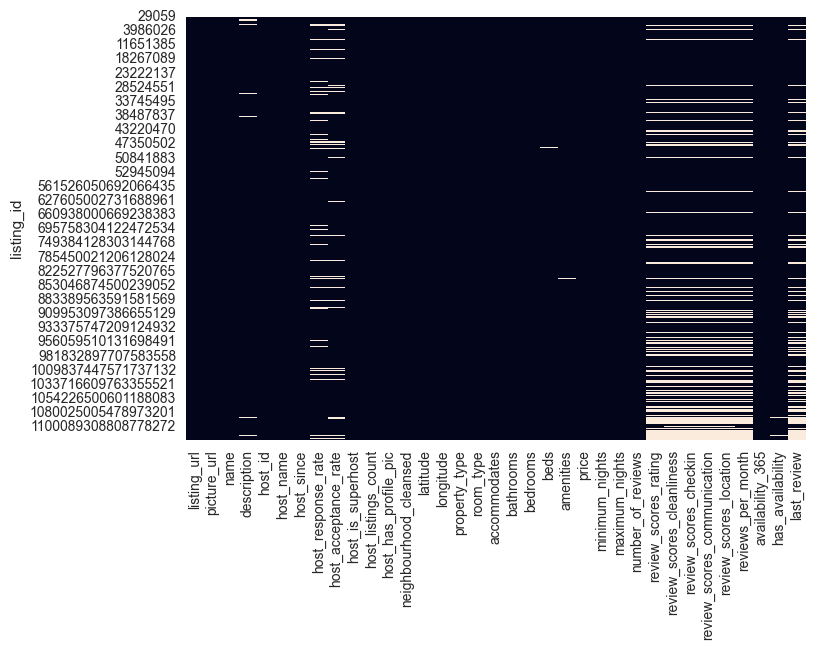

In [30]:
# I check the nulls in a heatmap:
sns.heatmap(listings1.isnull(), cbar=False)

In [31]:
# I check the percentage of nulls
nulls = listings1.isnull().sum()
nulls[nulls>0] 
nulls[nulls>0] / len(listings1) * 100 

description                     1.891892
host_response_rate             10.614251
host_acceptance_rate            8.230958
bathrooms                       0.049140
bedrooms                        0.085995
beds                            0.122850
amenities                       0.061425
price                           0.196560
review_scores_rating           20.307125
review_scores_cleanliness      20.405405
review_scores_checkin          20.417690
review_scores_communication    20.417690
review_scores_location         20.417690
reviews_per_month              20.319410
has_availability                0.651106
last_review                    20.319410
dtype: float64

In [32]:
def replace_nulls_with_mean(column):
    mean_value = column.mean()
    return column.fillna(mean_value)

columns_to_replace = ['bathrooms', 'bedrooms', 'beds', 'host_response_rate','host_acceptance_rate',
                      'review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'reviews_per_month',
                      'price']

listings1[columns_to_replace] = listings1[columns_to_replace].apply(replace_nulls_with_mean)


In [33]:
listings1['has_availability'] = listings1['has_availability'].fillna('f')

In [34]:
# After applying previous funcion, I check the percentage of nulls again:
nulls = listings1.isnull().sum()
nulls[nulls>0] 
nulls[nulls>0] / len(listings1) * 100 

description     1.891892
amenities       0.061425
last_review    20.319410
dtype: float64

### Treatment of outliers

In [35]:
# I use the function to see the number of outliers in our dataset according to interquartile ranges
def outliers (df):
    for columnas in df:
        if df[columnas].dtype in ['int64', 'float64']:  # check if the column in numeric

            Q1 = df[columnas].quantile(0.25)
            Q3 = df[columnas].quantile(0.75)
            IQR = Q3 - Q1
            outlierIzq = Q1-(1.5*IQR)
            outlierDer = Q3+(1.5*IQR)
            outliers = df[columnas][(df[columnas] < outlierIzq) | (df[columnas] > outlierDer)]
            print("Variable " + columnas + " has " + str(len(outliers)) + " outliers")
    
outliers(listings1)

Variable host_id has 0 outliers
Variable host_response_rate has 753 outliers
Variable host_acceptance_rate has 1010 outliers
Variable host_listings_count has 902 outliers
Variable latitude has 436 outliers
Variable longitude has 476 outliers
Variable accommodates has 678 outliers
Variable bathrooms has 1642 outliers
Variable bedrooms has 433 outliers
Variable beds has 937 outliers
Variable price has 619 outliers
Variable minimum_nights has 261 outliers
Variable maximum_nights has 2 outliers
Variable number_of_reviews has 758 outliers
Variable review_scores_rating has 599 outliers
Variable review_scores_cleanliness has 725 outliers
Variable review_scores_checkin has 614 outliers
Variable review_scores_communication has 637 outliers
Variable review_scores_location has 603 outliers
Variable reviews_per_month has 558 outliers
Variable availability_365 has 0 outliers


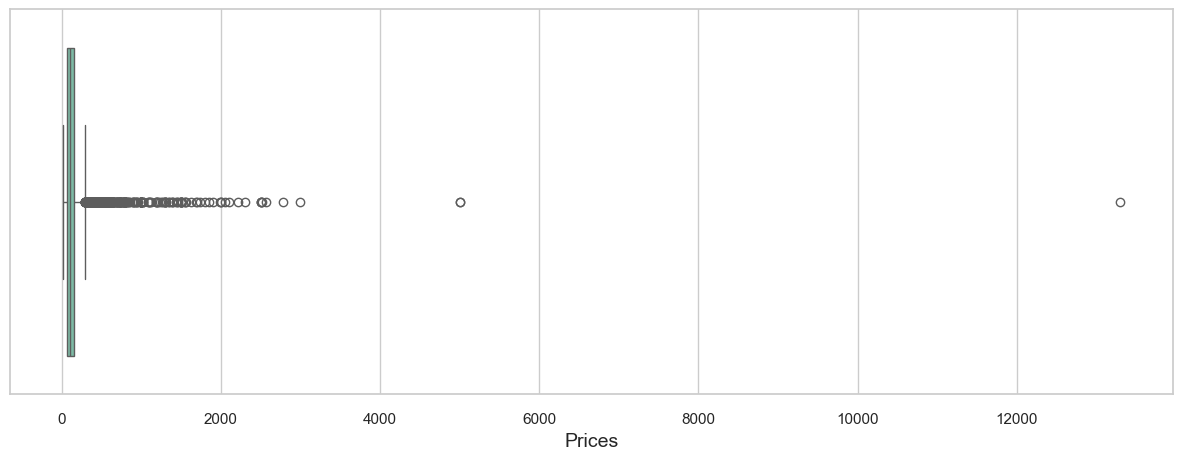

In [36]:
# Boxplot to see the outliers for the price
plt.figure(figsize=(15, 5))  
sns.set(style="whitegrid")  
fig = sns.boxplot(x="price", data=listings1, color = '#73C4A8')  
fig.set_xlabel('Prices', fontsize=14)
plt.show()

In [37]:
fig = px.box(listings1,
             x='price')
fig.show()

In [38]:
avg_price_by_accom = listings1.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
           
print(avg_price_by_accom)

neighbourhood_cleansed
Côte-Saint-Luc                              340.250000
L'Île-Bizard-Sainte-Geneviève               307.857143
Hampstead                                   267.000000
Baie-d'Urfé                                 237.571429
Pierrefonds-Roxboro                         200.588235
Westmount                                   200.142857
Dorval                                      197.687500
Outremont                                   191.075472
Le Plateau-Mont-Royal                       180.677476
Ville-Marie                                 161.861113
Montréal-Nord                               145.312500
Le Sud-Ouest                                136.088685
Rosemont-La Petite-Patrie                   134.189142
Sainte-Anne-de-Bellevue                     133.400000
Kirkland                                    131.333333
L'Île-Dorval                                124.000000
Rivière-des-Prairies-Pointe-aux-Trembles    120.684211
Lachine                                   

In [39]:
# I fix the outliers of the column "price":

def fix_outliers_with_tukey_extremes(df, columns):
    for column_name in columns:
            q1 = df[column_name].quantile(0.25)
            q3 = df[column_name].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            # Reemplaza los valores atípicos en el extremo inferior con el límite inferior
            df.loc[df[column_name] < lower_bound, column_name] = lower_bound
            
            # Reemplaza los valores atípicos en el extremo superior con el límite superior
            df.loc[df[column_name] > upper_bound, column_name] = upper_bound
    return df

fix_outliers_with_tukey_extremes(listings1, ['price'])

outliers(listings1)

Variable host_id has 0 outliers
Variable host_response_rate has 753 outliers
Variable host_acceptance_rate has 1010 outliers
Variable host_listings_count has 902 outliers
Variable latitude has 436 outliers
Variable longitude has 476 outliers
Variable accommodates has 678 outliers
Variable bathrooms has 1642 outliers
Variable bedrooms has 433 outliers
Variable beds has 937 outliers
Variable price has 0 outliers
Variable minimum_nights has 261 outliers
Variable maximum_nights has 2 outliers
Variable number_of_reviews has 758 outliers
Variable review_scores_rating has 599 outliers
Variable review_scores_cleanliness has 725 outliers
Variable review_scores_checkin has 614 outliers
Variable review_scores_communication has 637 outliers
Variable review_scores_location has 603 outliers
Variable reviews_per_month has 558 outliers
Variable availability_365 has 0 outliers


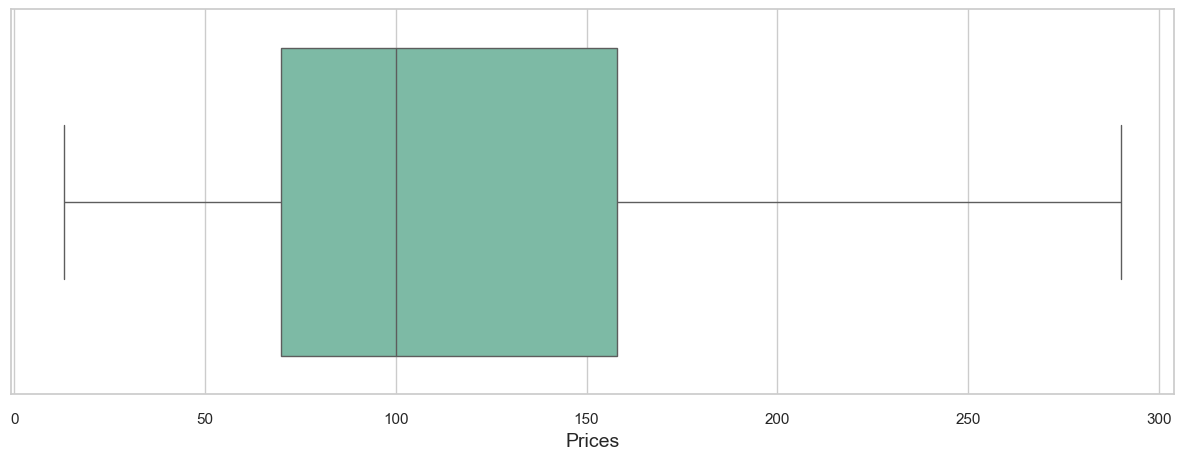

In [40]:
# Boxplot to check the column "price" fixed:
plt.figure(figsize=(15, 5))  
sns.set(style="whitegrid")  
fig = sns.boxplot(x="price", data=listings1, color = '#73C4A8')  
fig.set_xlabel('Prices', fontsize=14)
plt.show()

In [41]:
avg_price_by_accom = listings1.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
           
print(avg_price_by_accom)

neighbourhood_cleansed
L'Île-Bizard-Sainte-Geneviève               215.714286
Dorval                                      162.187500
Westmount                                   160.371429
Baie-d'Urfé                                 159.142857
Hampstead                                   156.900000
Côte-Saint-Luc                              156.875000
Le Plateau-Mont-Royal                       140.780071
Ville-Marie                                 136.636272
Outremont                                   134.981132
Pierrefonds-Roxboro                         131.705882
Sainte-Anne-de-Bellevue                     131.400000
Kirkland                                    131.333333
L'Île-Dorval                                124.000000
Rosemont-La Petite-Patrie                   115.730298
Le Sud-Ouest                                115.406728
Lachine                                     115.051282
Montréal-Nord                               112.062500
Dollard-des-Ormeaux                       

In [42]:
avg_price_by_accom = listings1.groupby('accommodates')['price'].mean().reset_index()

In [43]:
# Price VS Neghbourhood para 2 personas por noche

# Filtro el DataFrame para accommodates == 2
listings_accommodates_2 = listings1[listings1['accommodates'] == 2]

neigh_price = listings_accommodates_2.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=True)

custom_colors = ["#ffe8b6", "#fec98d", "#cd4457",
                 "#e04e4d", "#b93b4d", "#a92a5b",
                 "#781c6d", "#4a0c6b", "#1b0c45", "#000004"]

fig = px.bar(neigh_price,
             x=neigh_price.values,
             y=neigh_price.index,
             color=neigh_price.values,
             color_continuous_scale=custom_colors,
             text_auto=False,
             labels={'y': 'Neighbourhood', 'x': 'Average price/night', 'color': 'Average price/night'})

fig.update_layout(
    title='Precio promedio por noche para 2 personas',
    title_x=0.5,
    yaxis_title='Barrio',
    xaxis_title='Precio por noche',
    template='plotly_white',
    height=800,
    coloraxis_colorbar_title='Average price',
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False))

fig.show()

In [44]:
# Price VS Neghbourhood 

neigh_price = listings1.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=True)

custom_colors = ["#ffe8b6", "#fec98d", "#cd4457",
                 "#e04e4d", "#b93b4d", "#a92a5b",
                 "#781c6d", "#4a0c6b", "#1b0c45", "#000004"]

fig = px.bar(neigh_price,
             x=neigh_price.values,
             y=neigh_price.index,
             color=neigh_price.values,
             color_continuous_scale=custom_colors,
             text_auto=False,
             labels={'y': 'Neighbourhood', 'x': 'Average price/night', 'color': 'Average price/night'})

fig.update_layout(
    title='Precio promedio por noche para 2 personas',
    title_x=0.5,
    yaxis_title='Barrio',
    xaxis_title='Precio por noche',
    template='plotly_white',
    height=800,
    coloraxis_colorbar_title='Average price',
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False))

fig.show()

### Saving datasets

#### Dataset Listings

In [45]:
# I convert the index to column
listings1 = listings1.rename_axis('listing_id').reset_index()

In [46]:
listings1.head(1)

,listing_id,listing_url,picture_url,name,description,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,reviews_per_month,availability_365,has_availability,last_review
0,29059,https://www.airbnb.com/rooms/29059,https://a0.muscache.com/pictures/736399/fa6c31...,Lovely studio Quartier Latin,CITQ 267153<br />Lovely studio with 1 closed r...,125031,Maryline,2010-05-14,100.0,98.0,False,2,True,Ville-Marie,45.51939,-73.56482,Entire rental unit,Entire home/apt,4,1.0,1.0,3.0,"[""Books and reading material"", ""Paid parking l...",164.0,2,60,450,4.67,4.62,4.81,4.77,4.82,2.69,302,t,2024-03-16


In [47]:
# I will create groups of neighbourhood

geographical_groups = {
    'Ville-Marie': 'Central',
    'Le Plateau-Mont-Royal': 'Central',
    'Outremont': 'Central',
    'Le Sud-Ouest': 'Central',
    'Côte-des-Neiges-Notre-Dame-de-Grâce': 'Central',
    'Westmount': 'Central',
    'Ahuntsic-Cartierville': 'North',
    'Villeray-Saint-Michel-Parc-Extension': 'North',
    'Saint-Laurent': 'North',
    'Mont-Royal': 'North',
    'Montréal-Nord': 'North',
    'Mercier-Hochelaga-Maisonneuve': 'East',
    'Anjou': 'East',
    'Rivière-des-Prairies-Pointe-aux-Trembles': 'East',
    'Saint-Léonard': 'East',
    'Montréal-Est': 'East',
    'Lachine': 'West',
    'LaSalle': 'West',
    'Verdun': 'West',
    'Dorval': 'West',
    'Dollard-des-Ormeaux': 'West',
    'Pierrefonds-Roxboro': 'West',
    'Pointe-Claire': 'West',
    'Beaconsfield': 'West',
    'Baie-d Urfé': 'West',
    'Sainte-Anne-de-Bellevue': 'West',
    'Kirkland': 'West',
    "L'Île-Bizard-Sainte-Geneviève": 'West',
    "L'Île-Dorval": 'West',
    'Montréal-Ouest': 'West',
    'Hampstead': 'West',
    'Côte-Saint-Luc': 'West',
    'Rosemont-La Petite-Patrie': 'South',
    'Verdun': 'South'
}

listings1['geographical_group'] = listings1['neighbourhood_cleansed'].map(geographical_groups)

listings1[['neighbourhood_cleansed', 'geographical_group']].head()

,neighbourhood_cleansed,geographical_group
0,Ville-Marie,Central
1,Ville-Marie,Central
2,Le Plateau-Mont-Royal,Central
3,Ville-Marie,Central
4,Rosemont-La Petite-Patrie,South


In [48]:
# I rename the column "neighbourhood_cleansed" to "neighbourhood"
listings1 = listings1.rename(columns={'neighbourhood_cleansed': 'neighbourhood'})

In [49]:
# I save it
#listings1.to_csv('listings1_cleaned.csv', index=False)

#### Dataset Calendar

In [50]:
# I create a copy of the dataset calendar to keep also the original dataset.
calendar_cleaned = calendar.copy()

In [51]:
# I convert the index to column
calendar_cleaned = calendar_cleaned.rename_axis('listing_id').reset_index()

In [52]:
calendar_cleaned.head(1)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,29059,2024-03-23,False,$159.00,NaN,2,1125


In [53]:
# I fix the column of Price
calendar_cleaned['price'] = calendar_cleaned['price'].fillna('').astype(str).str.replace('$', '', regex=True).str.replace(',', '')
calendar_cleaned['price'] = calendar_cleaned['price'].replace('', 'nan').astype(float)

In [54]:
# I save it
calendar_cleaned.to_csv('calendar_cleaned.csv', index=False)

#### Dataset Reviews

In [55]:
# I create a copy of the dataset reviews to keep also the original dataset.
reviews_cleaned = reviews.copy()

In [56]:
# I convert the index to column
reviews_cleaned = reviews_cleaned.rename_axis('listing_id').reset_index()

In [57]:
reviews_cleaned.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,29059,55332,2010-06-20,116906,Yvette,This apt was soooo adorable! Centrally located...


In [58]:
# I save it
reviews_cleaned.to_csv('reviews_cleaned.csv', index=False)

## EDA (Exploratory Data Analysis)

- Correlation between variables.
- Distribution of the key variables. <br>
- Visualization of the distribution of the properties with a map of the city. <br>

### Correlation of variables

I will analyze the correlation between variables using the method of Spearman. I will explore the relation between them and check if there's any significant difference.

In [59]:
listings1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8140 entries, 0 to 8139
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   8140 non-null   int64  
 1   listing_url                  8140 non-null   object 
 2   picture_url                  8140 non-null   object 
 3   name                         8140 non-null   object 
 4   description                  7986 non-null   object 
 5   host_id                      8140 non-null   int64  
 6   host_name                    8140 non-null   object 
 7   host_since                   8140 non-null   object 
 8   host_response_rate           8140 non-null   float64
 9   host_acceptance_rate         8140 non-null   float64
 10  host_is_superhost            8140 non-null   bool   
 11  host_listings_count          8140 non-null   int64  
 12  host_has_profile_pic         8140 non-null   bool   
 13  neighbourhood     

In [60]:
# I convert the variables from int to float to study the correlation in the matrix:
listings1.loc[:,listings1.select_dtypes(include=np.number).columns] = (listings1.select_dtypes(include=np.number)).astype(float)

In [61]:
listings1.columns

Index(['listing_id', 'listing_url', 'picture_url', 'name', 'description',
       'host_id', 'host_name', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'reviews_per_month', 'availability_365', 'has_availability',
       'last_review', 'geographical_group'],
      dtype='object')

In [62]:
# I check the highest correlation and found that is "review_scores_rating" which i will use as my objective variable.
listings1.corr(method = 'spearman').abs().sum().sort_values(ascending=False)

review_scores_rating           5.361127
review_scores_communication    5.121816
review_scores_checkin          5.079581
review_scores_cleanliness      4.891491
reviews_per_month              4.801248
price                          4.600120
accommodates                   4.575662
number_of_reviews              4.471753
minimum_nights                 4.404310
beds                           4.351605
listing_id                     4.235607
bedrooms                       4.130008
host_is_superhost              4.041705
review_scores_location         3.861248
host_id                        3.740906
host_response_rate             3.309264
host_listings_count            3.124572
host_acceptance_rate           3.050352
bathrooms                      2.723619
maximum_nights                 2.384809
host_has_profile_pic           2.228802
longitude                      2.227369
latitude                       2.223595
availability_365               2.047239
dtype: float64

In [63]:
# Mido la asimetría de la variable "review_scores_rating" usando Skewness. 

skew(listings1['review_scores_rating'])

-4.708912926807298

Al tener una muestra mayor a 5000 usé el método de skewness para la verficación de la normalidad. Con skewness puedo comprobar que la distribución de los datos no es normal debido a que el valor de skewness es menor a 0.5, representando valores altos y positivos indicando la presencia de valores atípicos en la distribución.

 Rango de Valores de Skewness <br>
 - Entre -0.5 y 0.5: La distribución es aproximadamente simétrica. <br>
 - Entre -1 y -0.5 o entre 0.5 y 1: La distribución es moderadamente asimétrica. <br>
 - Menor que -1 o mayor que 1: La distribución es altamente asimétrica. <br>

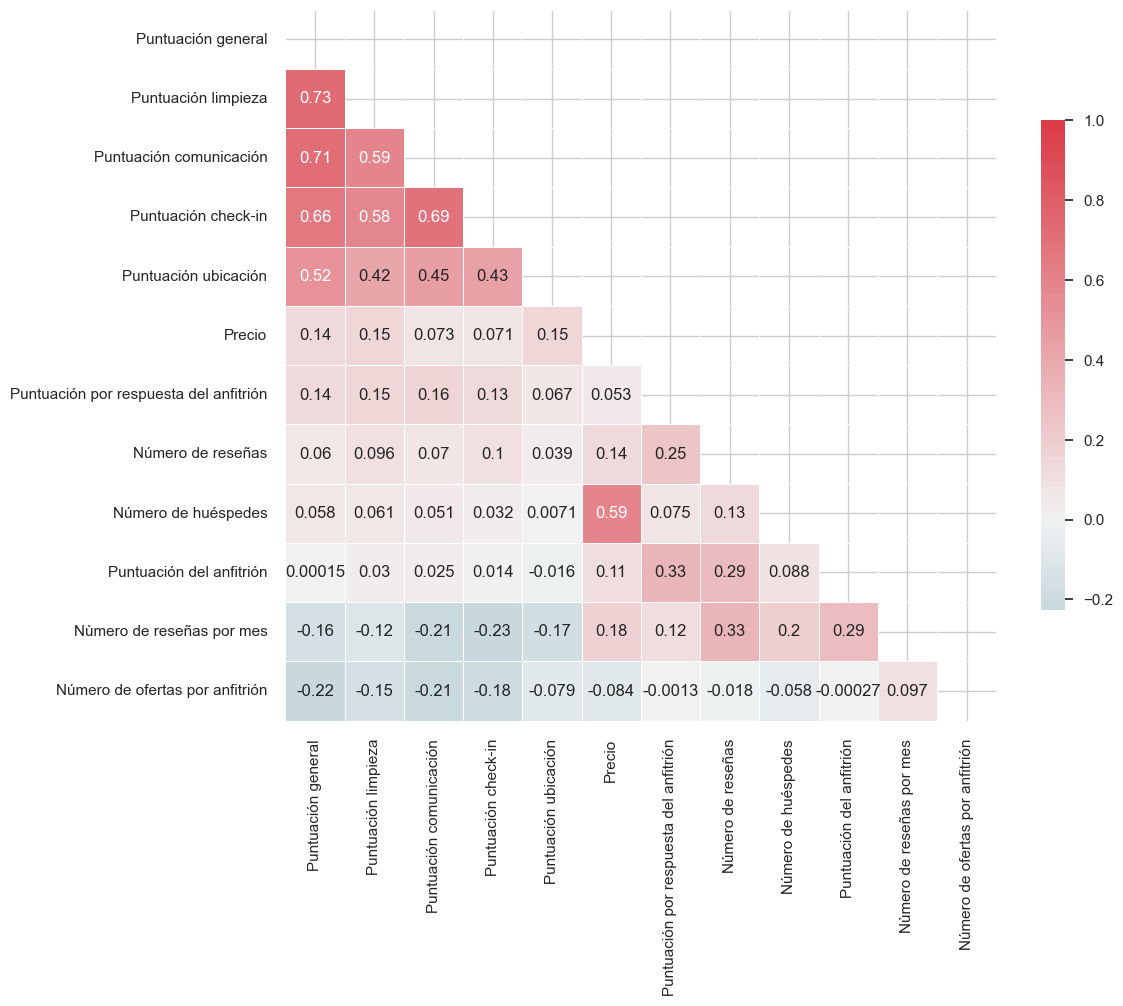

In [64]:
# I change the names of the variables
variables = listings1[['host_response_rate', 'host_acceptance_rate',
                       'host_listings_count', 'neighbourhood',
                       'accommodates', 'price', 'number_of_reviews', 'review_scores_rating',
                       'review_scores_cleanliness', 'review_scores_checkin',
                       'review_scores_communication', 'review_scores_location',
                       'reviews_per_month']].rename(columns={
    'host_response_rate': 'Puntuación por respuesta del anfitrión',
    'host_acceptance_rate': 'Puntuación del anfitrión',
    'host_listings_count': 'Número de ofertas por anfitrión',
    'neighbourhood': 'Barrio',
    'accommodates': 'Número de huéspedes',
    'price': 'Precio',
    'number_of_reviews': 'Número de reseñas',
    'review_scores_rating': 'Puntuación general',
    'review_scores_cleanliness': 'Puntuación limpieza',
    'review_scores_checkin': 'Puntuación check-in',
    'review_scores_communication': 'Puntuación comunicación',
    'review_scores_location': 'Puntuación ubicación',
    'reviews_per_month': 'Nùmero de reseñas por mes'
})

# I do a heatmap to see the correlation between the continuous variables. I use the method "spearman" since the variables are not following a normal distribution.
corr = variables.corr(method='spearman').sort_values(by='Puntuación general', axis=0, ascending=False).sort_values(by='Puntuación general', axis=1, ascending=False)

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(12, 12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)  # annot=True para ver los valores en el gráfico

plt.tight_layout()


Analysis of the correlation: <br>

- Positive (0 a 1): A positive value close to 1 indicate a **strong positive correlation** (when one of them increase, the other one as well). <br>
- Negative (-1 a 0): A negative value close to 1 indicate a **strong negative correlation** (when one of them increase, the other one decrease). <br>
- Zero (0): Indicate that there's **no correlation** between variables.

Conclusions from the correlation graph:<br>

- **Scores rating** has a strong correlation with the scores **cleanliness, communication, checkin, location and superhost**.
- **Price** has a strong correlation with **accommodates**.

I will do the graphs of the variables with higher correlation with "reviews_scores_rating".

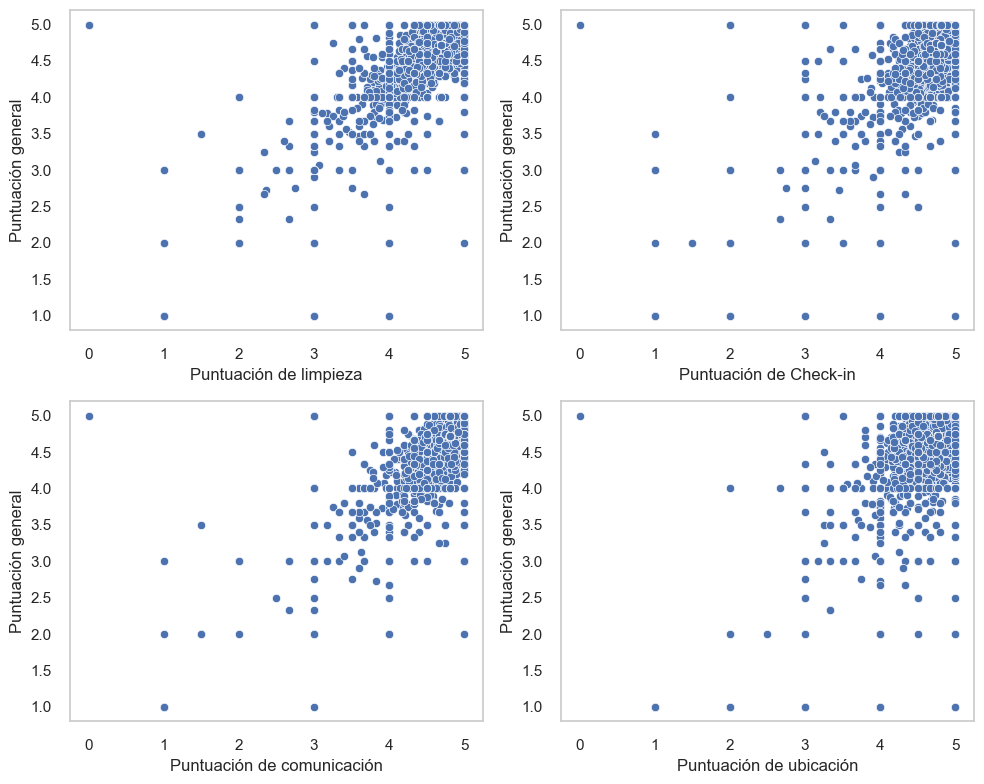

In [65]:
sns.set(style="whitegrid")

# Variables y sus nuevos nombres
variables = {
    'review_scores_cleanliness': 'Puntuación de limpieza',
    'review_scores_checkin': 'Puntuación de Check-in',
    'review_scores_communication': 'Puntuación de comunicación',
    'review_scores_location': 'Puntuación de ubicación'
}

# Creo el gráfico
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Itero sobre las variables y sus nombres
for ax, (var, var_name) in zip(axes.flatten(), variables.items()):
    sns.scatterplot(x=var, y='review_scores_rating', data=listings1, ax=ax)
    ax.set_xlabel(var_name)
    ax.set_ylabel('Puntuación general',
    ax.grid(False))

plt.tight_layout()
plt.show()


In [66]:
# I change "accommodates" from float to int:
listings1['accommodates'] = listings1['accommodates'].astype(int)

# I change "bedrooms" from float to int:
listings1['bedrooms'] = listings1['bedrooms'].astype(int)

In [67]:
# I save it
listings1.to_csv('listings1_cleaned.csv', index=False)

### A/B Testing

#### A/B Testing: Precio VS tipo de propiedad

- H0 (hipotesis nula): El tipo de propiedad no tiene un impacto significativo en el precio de la vivienda.
- H1 (hipotesis alternativa): El tipo de propiedad sí tiene un impacto significativo en el precio de la vivienda.

In [68]:
# Mido la asimetría de la variable "Precio" usando Skewness. 

skew(listings1['price'])

0.9866303685183836

Al tener una muestra mayor a 5000 usé el método de skewness para la verficación de la normalidad. Con skewness puedo comprobar que la distribución de los datos no es normal debido a que el valor de skewness es mayor a 0.5, representando valores altos y positivos indicando la presencia de valores atípicos en la distribución.

 Rango de Valores de Skewness <br>
 - Entre -0.5 y 0.5: La distribución es aproximadamente simétrica. <br>
 - Entre -1 y -0.5 o entre 0.5 y 1: La distribución es moderadamente asimétrica. <br>
 - Menor que -1 o mayor que 1: La distribución es altamente asimétrica. <br>

El resultado es 0.9866, esto significa que la distribución de los precios (price) es moderadamente asimétrica.

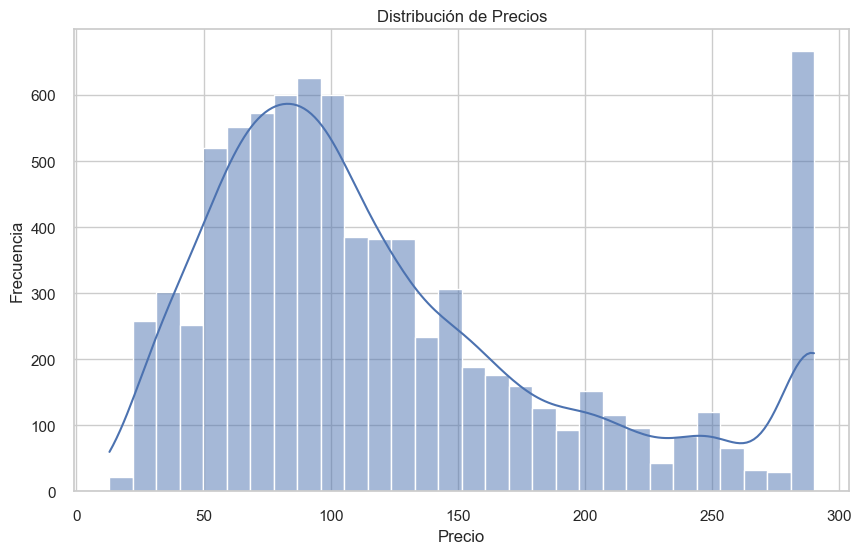

In [69]:
# Para tener una mejor comprensión de cómo se ve esta asimetría en la distribución de precios, hago un histograma:

plt.figure(figsize=(10, 6))
sns.histplot(listings1['price'], kde=True, bins=30)
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

In [70]:
groups = [group['price'].values for name, group in listings1.groupby('property_type')]
f_stat, p_value = stats.f_oneway(*groups)
print( p_value)

0.0


Como el valor me da 0 < 0.05 entonces rechazo la hipótesis nula.<br>
**Al rechazar la hipótesis nula, significa que el tipo de propiedad sí tiene un impacto significativo en el precio de la vivienda.**

#### AB/Testing: Precio VS ubicación

- H0 (hipotesis nula): La ubicación no tiene un impacto significativo en el precio de la vivienda.
- H1 (hipotesis alternativa): La ubicación sí tiene un impacto significativo en el precio de la vivienda.

In [71]:
groups = [group['price'].values for name, group in listings1.groupby('neighbourhood')]
f_stat, p_value = stats.f_oneway(*groups)
print( p_value)

4.649917821304319e-90


Como el valor me da mayor a 0.05 entonces acepto la hipótesis nula.<br>
**Al aceptar la hipótesis nula, significa que la ubicación NO tiene un impacto significativo en el precio de la vivienda.**

### Price

In [72]:
# Price VS accommodates

avg_price_by_accom = listings1.groupby('accommodates')['price'].mean().reset_index()

fig = px.bar(avg_price_by_accom,
                         x='accommodates',
                         y='price',
                         title='')
            
fig.update_traces(marker_color=' #16A085')

fig.update_layout(
    title = 'Precio promedio por noche por número de huéspedes',
    xaxis_title='Cantidad de huéspedes',
    yaxis_title='Precio promedio por noche',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    showlegend=False,
    template='plotly_white')

fig.show()

In [73]:
#fig.write_html("precio_accommodates.html")

In [74]:
# Price VS number of rooms:

fig = px.box(listings1,
             x='bedrooms',
             y='price',
             title='Price VS Number of Rooms')

fig.update_layout(
    xaxis_title='Number of Rooms',
    yaxis_title='Price'
)

fig.show()


In [75]:
# Price VS number of bedrooms

avg_price_by_bedrooms = listings1.groupby('bedrooms')['price'].mean().reset_index().sort_values(by='price', ascending=False)
           
fig = px.bar(avg_price_by_bedrooms,
                         x='bedrooms',
                         y='price',
                         title='')
            
fig.update_traces(marker_color=' #AF7AC5')

fig.update_layout(
    title = ' Precio promedio por número de dormitorios',
    xaxis_title='Número de dormitorios',
    yaxis_title='Precio promedio por noche',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    showlegend=False)

fig.show()

In [76]:
#fig.write_html("precio_dormitorios.html")

This shows that the price increase gradually with the number of rooms.

In [77]:
# Price VS room type:

fig = px.box(listings1,
             x='room_type',
             y='price',
             title='Price VS room type')

fig.update_layout(
    xaxis_title='Room type',
    yaxis_title='Price'
)

fig.show()

In [78]:
# Price VS Room type

avg_price_by_room_type = listings1.groupby('room_type')['price'].mean().reset_index().sort_values(by='price', ascending=False)

colors = ['#16A085','#ABEBC6','#DCD0FF','#DCD0FF']

fig = px.bar(avg_price_by_room_type,
                         x='room_type',
                         y='price',
                         title='Precio promedio por noche por tipo de alojamiento',
                         color = 'room_type',
                         color_discrete_sequence= colors)

fig.update_layout(
                 xaxis_title='',
                 yaxis_title='Precio promedio por noche',
                 xaxis_showgrid=False,
                 yaxis_showgrid=False,
                 showlegend=False,
                 template='plotly_white')

fig.show()

In [79]:
#fig.write_html("precio_roomtype.html")

The avg price of a hotel room is higher than an entire home/apt.<br>
There's no difference between a private room and a shared room.

In [80]:
# Price VS Neghbourhood 

neigh_price = listings1.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)

custom_colors = ["#ffe8b6", "#fec98d", "#cd4457",
                 "#e04e4d", "#b93b4d", "#a92a5b",
                 "#781c6d", "#4a0c6b", "#1b0c45", "#000004"]

fig = px.bar(neigh_price,
             x=neigh_price.values,
             y=neigh_price.index,
             color=neigh_price.values,
             color_continuous_scale=custom_colors,
             text_auto=False,
             labels={'y': 'Neighbourhood', 'x': 'Average price/night', 'color': 'Average price/night'})

fig.update_layout(
    title='Precio promedio por noche',
    title_x=0.5,
    yaxis_title='Barrio',
    xaxis_title='Precio por noche',
    template='plotly_white',
    height=800,
    coloraxis_colorbar_title='Average price',
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False))

fig.show()

In [81]:
#fig.write_html("precio_barrio.html")

In [82]:
# Price VS Neghbourhood para 2 personas por noche

# Filtro el DataFrame para accommodates == 2
listings_accommodates_2 = listings1[listings1['accommodates'] == 2]

neigh_price = listings_accommodates_2.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)

custom_colors = ["#ffe8b6", "#fec98d", "#cd4457",
                 "#e04e4d", "#b93b4d", "#a92a5b",
                 "#781c6d", "#4a0c6b", "#1b0c45", "#000004"]

fig = px.bar(neigh_price,
             x=neigh_price.values,
             y=neigh_price.index,
             color=neigh_price.values,
             color_continuous_scale=custom_colors,
             text_auto=False,
             labels={'y': 'Neighbourhood', 'x': 'Average price/night', 'color': 'Average price/night'})

fig.update_layout(
    title='Precio promedio por noche para 2 personas',
    title_x=0.5,
    yaxis_title='Barrio',
    xaxis_title='Precio por noche',
    template='plotly_white',
    height=800,
    coloraxis_colorbar_title='Average price',
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False))

fig.show()


In [83]:
calendar_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2971100 entries, 0 to 2971099
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       bool          
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  int64         
 6   maximum_nights  int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3)
memory usage: 138.8 MB


Evolución de precios:

In [84]:
# Evolucion de precios
# Añado la columna date del dataset calendar_cleaned a listings1:

listings1['date'] = calendar_cleaned['date']

listings1['date'] = pd.to_datetime(listings1['date'])

In [85]:
# Creo la columna month en listings1:

listings1['month'] = listings1['date'].dt.to_period('M')

# Lo convierto en string:
listings1['month'] = listings1['month'].astype(str)

In [86]:
# Ahora saco la media de los precios por mes:

media = listings1.groupby('month')['price'].mean()
media

month
2024-03    115.183803
2024-04    124.013112
2024-05    124.774260
2024-06    124.733470
2024-07    119.741534
2024-08    121.693756
2024-09    124.059091
2024-10    119.250733
2024-11    123.856204
2024-12    128.532327
2025-01    121.202415
2025-02    127.373453
2025-03    129.795455
Name: price, dtype: float64

In [87]:
# Grafico: Evolución de precio promedio por mes

fig = px.line(media,
              x=media.index,
              y=media.values,
              title= 'Evolución de precio promedio por mes')

fig.update_xaxes(title_text='Mes')
fig.update_yaxes(title_text='Precio promedio')

fig.show()

In [88]:
#fig.write_html("grafico_price_evolution.html")

### Neighbourhood

I will analyze the distribution of the listings in Montreal using a bar graph and a map of the city. 

In [89]:
# Distribution of the listings

neigh_listings = listings1['neighbourhood'].value_counts().sort_values(ascending=True)
custom_colors = ["#ffe8b6", "#fec98d", "#cd4457",
                 "#e04e4d", "#b93b4d", "#a92a5b",
                 "#4a0c6b", "#1b0c45", "#000004"]

fig = px.bar(neigh_listings,
             x=neigh_listings.values,
             y=neigh_listings.index,
             color=neigh_listings.values,
             color_continuous_scale= custom_colors,
             text_auto = False)

fig.update_layout(
    title ='Distribución de alojamientos por barrio',
    title_x =0.5, 
    yaxis_title = 'Barrio',
    xaxis_title = 'Nº de alojamientos',
    template = 'plotly_white',
    height=800,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)) 

fig.show()

In [90]:
#fig.write_html("distribucion_alojamientos.html")

The majority of the listings are in the city center (Ville-Marie).

In [91]:
latitudes = listings1['latitude'].tolist()
longitudes = listings1['longitude'].tolist()
coordenadas = list(zip(latitudes,longitudes))

In [92]:
# I create a map to see the distribution of the listings all around the city.

latitud_1 = listings1['latitude'].mean()
longitud_1 = listings1['longitude'].mean()

map1_barrios = folium.Map(location = [latitud_1,longitud_1],zoom_start=11.5)

FastMarkerCluster(data=coordenadas).add_to(map1_barrios)
folium.Marker(location=[latitud_1,longitud_1]).add_to(map1_barrios)

map1_barrios

In [93]:
#map1_barrios.save("map1_barrios.html")

In [94]:
neighbourhoods_geojson.columns

Index(['neighbourhood', 'neighbourhood_group', 'geometry'], dtype='object')

In [95]:
listings1.columns

Index(['listing_id', 'listing_url', 'picture_url', 'name', 'description',
       'host_id', 'host_name', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'reviews_per_month', 'availability_365', 'has_availability',
       'last_review', 'geographical_group', 'date', 'month'],
      dtype='object')

In [130]:
# Map to see the average prices

# Calculate mean price by neighborhood for listings 
mean_prices = listings1.groupby('neighbourhood')['price'].mean()

# Join the mean prices to the geojson
geo_prices = neighbourhoods_geojson.join(mean_prices, on='neighbourhood')

# Drop neighborhoods without mean prices
geo_prices.dropna(subset=['price'], inplace=True)

# Round the mean prices and create a dictionary for the color map
price_dict = geo_prices.set_index('neighbourhood')['price'].round().to_dict()

# Define color map
color_scale = LinearColormap(['green', 'yellow', 'red'], vmin=min(price_dict.values()), vmax=max(price_dict.values()), caption='Average price')

# Define style and highlight functions
def style_function(feature):
    return {
        'fillColor': color_scale(price_dict.get(feature['properties']['neighbourhood'], 0)),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.5
    }

def highlight_function(feature):
    return {
        'weight': 3,
        'fillColor': color_scale(price_dict.get(feature['properties']['neighbourhood'], 0)),
        'fillOpacity': 0.8
    }

# Create map
map2_prices = folium.Map(location = [latitud_1,longitud_1],zoom_start=10)

# Add geojson layer to map with tooltip and style and highlight functions
folium.GeoJson(
    data=geo_prices,
    name='Montreal',
    tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'price'], labels=True, sticky=False),
    style_function=style_function,
    highlight_function=highlight_function
).add_to(map2_prices)

# Add marker to map
folium.Marker(location = [latitud_1,longitud_1],zoom_start=10)

# Add color scale to map
map2_prices.add_child(color_scale)

map2_prices

In [131]:
map2_prices.save("map2_prices.html")

In [96]:
# Map to see the average prices for 2 people

listings_accommodates_2 = listings1[listings1['accommodates'] == 2]

# Calculate mean price by neighborhood for listings 
mean_prices = listings_accommodates_2.groupby('neighbourhood')['price'].mean()

# Join the mean prices to the geojson
geo_prices = neighbourhoods_geojson.join(mean_prices, on='neighbourhood')

# Drop neighborhoods without mean prices
geo_prices.dropna(subset=['price'], inplace=True)

# Round the mean prices and create a dictionary for the color map
price_dict = geo_prices.set_index('neighbourhood')['price'].round().to_dict()

# Define color map
color_scale = LinearColormap(['green', 'yellow', 'red'], vmin=min(price_dict.values()), vmax=max(price_dict.values()), caption='Average price')

# Define style and highlight functions
def style_function(feature):
    return {
        'fillColor': color_scale(price_dict.get(feature['properties']['neighbourhood'], 0)),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.5
    }

def highlight_function(feature):
    return {
        'weight': 3,
        'fillColor': color_scale(price_dict.get(feature['properties']['neighbourhood'], 0)),
        'fillOpacity': 0.8
    }

# Create map
map2_prices = folium.Map(location = [latitud_1,longitud_1],zoom_start=10)

# Add geojson layer to map with tooltip and style and highlight functions
folium.GeoJson(
    data=geo_prices,
    name='Montreal',
    tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'price'], labels=True, sticky=False),
    style_function=style_function,
    highlight_function=highlight_function
).add_to(map2_prices)

# Add marker to map
folium.Marker(location = [latitud_1,longitud_1],zoom_start=10)

# Add color scale to map
map2_prices.add_child(color_scale)

map2_prices

In [98]:
# Heatmap for the prices for 2 people per night

# Get the minimum and maximum price values

min_price = listings_accommodates_2['price'].min()
max_price = listings_accommodates_2['price'].max()
# Define the color scale for the legend
color_scale = LinearColormap(['green', 'yellow', 'red'],
                             vmin=min_price,
                             vmax=max_price,
                             caption='Precio')

# Create the map
map3_heatmap_price = folium.Map(location = [latitud_1,longitud_1],zoom_start=10)

# Add a heatmap to the base map
HeatMap(data=listings_accommodates_2[['latitude', 'longitude', 'price']],
        radius=20,
        gradient={0.2: 'green', 0.5: 'yellow', 1: 'red'},
        min_opacity=0.2).add_to(map3_heatmap_price)

# Add the color scale legend
map3_heatmap_price.add_child(color_scale)

map3_heatmap_price


In [99]:
#map3_heatmap_price.save("map3_heatmap_price.html")

### Room type

I will analyze the type of rooms and distribution that are listed.

In [100]:
listings1['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [101]:
# Number of listings VS type of room

num_accommodates_2 = listings1[listings1['accommodates'] == 2].shape[0]

# Distribución de los tipos de alojamiento
room_type = listings1['room_type'].value_counts().sort_values(ascending=False)

fig = px.bar(room_type,
             x=room_type.values,
             y=room_type.index,
             orientation='h',  
             color=room_type.index,
             title='Cantidad de ofertas por tipo de alojamiento',
             width=800,
             height=500)

fig.update_traces(marker_color='#AF7AC5')

fig.update_layout(
             showlegend=False,
             xaxis_title='Cantidad de alojamientos',
             yaxis_title='',
             xaxis_showgrid=False,
             yaxis_showgrid=False,
             plot_bgcolor='white',  
             paper_bgcolor='white')

# Añadir una línea vertical para indicar el número de alojamientos para 2 personas
fig.add_shape(
    type='line',
    x0=num_accommodates_2,
    y0=-0.5,  # Para que la línea cubra todo el gráfico
    x1=num_accommodates_2,
    y1=len(room_type) - 0.5,
    line=dict(color='red', width=2, dash='dash'))


fig.show()

In [102]:
#fig.write_html("room_type.html")

In [103]:
accommodates_2 = listings1[listings1['accommodates'] == 2]['room_type'].count()
print('listings for 2 people:', accommodates_2)

listings for 2 people: 3055


In [104]:
porcentaje = accommodates_2 / len(listings1['room_type']) * 100
print('porcentaje de alojamientos para 2 personas:', porcentaje)

porcentaje de alojamientos para 2 personas: 37.53071253071253


The mayority of listings are entire home/appartment, followed by private room.<br>
Shared room and hotel room are not so popular in Airbnb in Montreal.

In [105]:
# En porcentaje:

room_type_counts = listings1['room_type'].value_counts().sort_values(ascending=False)
room_type_percent = room_type_counts / room_type_counts.sum() * 100

fig = px.bar(room_type_percent,
             x=room_type_percent.values,
             y=room_type_percent.index,
             orientation='h',
             color=room_type_percent.index,
             title='Room Type Distribution (Percentage)',
             width=800,
             height=500)

fig.update_layout(
    showlegend=True,
    xaxis_title='Percentage',
    template='plotly_white',
    xaxis_showgrid=False,
    yaxis_showgrid=False)

fig.show()

### Property type

We learnt from previous graph that the most popular type are entire home and private room. So now I will analyze the top 200 accomodations between them.

Top 200 accomodations:

In [106]:
listings1['property_type'].value_counts()

Entire rental unit                    4842
Entire condo                           841
Private room in rental unit            778
Entire home                            299
Private room in home                   271
Entire loft                            239
Entire serviced apartment              183
Room in aparthotel                     109
Room in hotel                          109
Entire townhouse                        99
Private room in condo                   72
Private room in townhouse               34
Private room in bed and breakfast       31
Entire guest suite                      29
Private room in bungalow                24
Room in boutique hotel                  22
Private room in hostel                  21
Entire bungalow                         14
Entire cottage                          12
Shared room in hostel                   11
Entire villa                            11
Private room in loft                    11
Private room in guest suite              9
Shared room

In [107]:
property_acc = listings1.groupby(['property_type', 'room_type']).size().reset_index(name='count')
property_acc = property_acc[property_acc['count']>200].sort_values(by=['count'])

fig = px.bar(property_acc,
             x='count',
             y='property_type',
             color='room_type',
             )  

fig.update_layout(yaxis={'categoryorder':'total ascending'},
    title='Top 200 accommodations',
    title_x=0.5, 
    yaxis_title='Property type',
    xaxis_title= '',
    template='plotly_white',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
	width=800,
    height=400,
    legend_title='Room/apt type')


fig.show()

The most popular accommodation in Airbnb in Montreal is the entire rental unit, followed by entire condo.

### Accommodates

I will analyze how many listings are depending on the number of people staying in the booking.

In [108]:
listings1['accommodates'].value_counts().sort_index(ascending=True)

1      573
2     3055
3      572
4     1931
5      378
6      839
7      114
8      264
9       46
10     113
11      13
12      53
13      15
14      30
15      13
16     131
Name: accommodates, dtype: int64

In [109]:
numb_accomm = listings1['accommodates'].value_counts().sort_index()

colors = ['#ABEBC6' if x != 2 else '#FA8072' for x in numb_accomm.index]

fig = px.bar(numb_accomm,
             x=numb_accomm.index,
             y=numb_accomm.values,
             title='Distribución de alojamientos por cantidad de huéspedes')

fig.update_traces(marker_color=colors)

fig.update_layout(
             title='Cantidad de ofertas por número de huéspedes',
             title_x=0.35,
             yaxis_title='Nº de alojamientos',
             xaxis_title='Cantidad de huéspedes',
             template='plotly_white',
             xaxis_showgrid=False,
             yaxis_showgrid=False,
             width=800,
             height=500)

In [110]:
#fig.write_html("accommodates.html")

Most of the listings are for 2 people, followed by listings for 4 people.

### Availability

I will analyze the availability of the listings in the different neighbourhoods.

In [111]:
montreal_center = dict(lat=45.5017, lon=-73.5673)

color_scale = LinearColormap(['green', 'yellow', 'red'],
                             caption='availability_365')

# Create the map
map4_availability = folium.Map(location = [45.5017, -73.5673],zoom_start=10)

# Add a heatmap to the base map
HeatMap(data=listings1[['latitude', 'longitude', 'availability_365']],
        radius=20,
        gradient={0.2: 'green', 0.5: 'yellow', 1: 'red'},
        min_opacity=0.2).add_to(map4_availability)

# Add the color scale legend
map4_availability.add_child(color_scale)

map4_availability

In [112]:
# map4_availability.save("map4_availability.html")

In [113]:
filtered_listings = listings1[listings1['has_availability'] == 't']
          
availab = filtered_listings.groupby('neighbourhood').size().reset_index(name='availability_count').sort_values(by='availability_count', ascending=True)

fig.update_traces(marker_color='#AF7AC5')

fig = px.bar(availab,
            x='availability_count',
            y='neighbourhood',
            title='Disponibilidad por barrio',
            height=700)
          
fig.update_layout(
    xaxis_title='Nº de alojamientos disponibles',
    yaxis_title='Barrio',
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False),
    template = 'plotly_white')

fig.show()

In [114]:
# fig.write_html('availability_neigh.html')

In [115]:
filtered_listings = listings1[listings1['has_availability'] == 't']

availab = filtered_listings.groupby('room_type').size().reset_index(name='availability_count').sort_values(by='availability_count', ascending=True)

fig = px.bar(
    availab,
    x='availability_count',
    y='room_type',
    color=room_type.index,
    title='Disponibilidad por tipo de alojamiento',
    height=700)

fig.update_traces(marker_color='#AF7AC5')

fig.update_layout(
    showlegend=False,
    xaxis_title='Nº de alojamientos disponibles',
    yaxis_title='',
    xaxis=dict(showgrid=False),  
    yaxis=dict(showgrid=False),
    template = 'plotly_white')

fig.show()

In [116]:
# fig.write_html('availability_roomtype.html')

### Analysis of Superhost

In [117]:
superh = listings1[listings1['host_is_superhost'] == True]['host_id'].count()
not_superh = listings1[listings1['host_is_superhost'] == False]['host_id'].count()
total_host = superh + not_superh
porcentaje_superh = (superh / total_host) * 100
porcentaje_notsuperh = (not_superh / total_host) * 100

porcentajes = [porcentaje_superh, porcentaje_notsuperh]
etiquetas = ['Superhost', 'Not superhost']

colors = ['#D2B48C', '#FFCC99']

fig = px.pie(names=etiquetas, values=porcentajes, 
             color=etiquetas, color_discrete_map=dict(zip(etiquetas, colors)))

fig.update_layout(title='Superhost VS not superhost',
                  showlegend=True,  # Mostrar la leyenda
                  legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
                  yaxis_title='',
                  xaxis_title='')

fig.show()

## Predicción de precios

In [118]:
df = pd.read_csv(r"C:\Users\Dai\Desktop\Bootcamp_Upgrade_Hub\Data_Bootcamp\Modulo_2\Proyecto_Airbnb\notebooks\listings1_cleaned.csv")

In [119]:
df.head()

,listing_id,listing_url,picture_url,name,description,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,reviews_per_month,availability_365,has_availability,last_review,geographical_group
0,29059.0,https://www.airbnb.com/rooms/29059,https://a0.muscache.com/pictures/736399/fa6c31...,Lovely studio Quartier Latin,CITQ 267153<br />Lovely studio with 1 closed r...,125031.0,Maryline,2010-05-14,100.0,98.0,False,2.0,True,Ville-Marie,45.51939,-73.56482,Entire rental unit,Entire home/apt,4,1.0,1,3.0,"[""Books and reading material"", ""Paid parking l...",164.0,2.0,60.0,450.0,4.67,4.62,4.81,4.77,4.82,2.69,302.0,t,2024-03-16,Central
1,29061.0,https://www.airbnb.com/rooms/29061,https://a0.muscache.com/pictures/9e59d417-4b6a...,Maison historique - Quartier Latin,Lovely historic house with plenty of period ch...,125031.0,Maryline,2010-05-14,100.0,98.0,False,2.0,True,Ville-Marie,45.51929,-73.56493,Entire home,Entire home/apt,4,1.0,2,2.0,"[""Books and reading material"", ""Coffee maker: ...",290.0,2.0,21.0,130.0,4.73,4.66,4.88,4.81,4.87,0.88,348.0,t,2024-02-19,Central
2,36301.0,https://www.airbnb.com/rooms/36301,https://a0.muscache.com/pictures/26c20544-475f...,Romantic & peaceful Plateau loft,"Enjoy the best of Montreal in this romantic, ...",381468.0,Sylvie,2011-02-07,94.0,80.0,True,8.0,True,Le Plateau-Mont-Royal,45.53026,-73.58413,Entire rental unit,Entire home/apt,2,1.0,1,2.0,"[""Microwave"", ""Free street parking"", ""Shampoo""...",175.0,32.0,730.0,51.0,4.86,4.86,4.92,4.90,4.88,0.47,81.0,t,2024-01-07,Central
3,38118.0,https://www.airbnb.com/rooms/38118,https://a0.muscache.com/pictures/213997/763ec1...,Beautiful room with a balcony in front of a parc,Nearest metro Papineau.,163569.0,M.,2010-07-11,78.0,0.0,False,1.0,True,Ville-Marie,45.52699,-73.55840,Private room in rental unit,Private room,1,1.0,3,4.0,"[""Carbon monoxide alarm"", ""Free street parking...",50.0,31.0,60.0,16.0,4.50,4.25,4.81,4.81,4.63,0.10,299.0,t,2022-08-29,Central
4,50479.0,https://www.airbnb.com/rooms/50479,https://a0.muscache.com/pictures/miso/Hosting-...,L'Arcade Douce,The appartement is sunny and ideally situated ...,231694.0,Noemie,2010-09-11,100.0,100.0,True,2.0,True,Rosemont-La Petite-Patrie,45.54157,-73.60737,Entire rental unit,Entire home/apt,3,1.0,2,2.0,"[""Books and reading material"", ""Electric stove...",90.0,3.0,28.0,263.0,4.95,4.94,4.97,4.98,4.84,1.60,0.0,t,2024-03-18,South


In [120]:
df.columns

Index(['listing_id', 'listing_url', 'picture_url', 'name', 'description',
       'host_id', 'host_name', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'reviews_per_month', 'availability_365', 'has_availability',
       'last_review', 'geographical_group'],
      dtype='object')

In [121]:
# Creo una seleccion de variables que quiero utilizar:
df_pred_new = df[["neighbourhood","accommodates", "room_type", "bedrooms", "bathrooms", "minimum_nights", "price"]]
# df_pred_new es el DataFrame que contiene los datos que voy a utilizar para el modelado.


In [122]:
df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [123]:
setup = setup(df_pred_new, target='price') # Target: El parámetro target especifica la columna que voy a predecir. En este caso, la columna objetivo es 'price'.

,Description,Value
0,Session id,2822
1,Target,price
2,Target type,Regression
3,Original data shape,"(8140, 7)"
4,Transformed data shape,"(8140, 10)"
5,Transformed train set shape,"(5698, 10)"
6,Transformed test set shape,"(2442, 10)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


In [124]:
# Comparo los modelos
best = compare_models()
# Después de ejecutar setup, creo y entreno varios modelos. PyCaret permite comparar automáticamente diferentes modelos y seleccionar el mejor, en este caso GBR

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,36.7808,2524.1320,50.1925,0.5341,0.3923,0.3490,0.2160
gbr,Gradient Boosting Regressor,37.4971,2581.5480,50.7517,0.5234,0.4014,0.3617,0.0410
xgboost,Extreme Gradient Boosting,37.0913,2639.9506,51.3307,0.5125,0.3996,0.3505,0.0240
rf,Random Forest Regressor,37.1778,2686.8189,51.7595,0.5038,0.4032,0.3498,0.0760
et,Extra Trees Regressor,37.5912,2846.8600,53.2466,0.4742,0.4103,0.3516,0.0660
lr,Linear Regression,41.2243,2997.1715,54.6872,0.4467,0.4413,0.4088,0.3140
ridge,Ridge Regression,41.2347,2997.1075,54.6870,0.4467,0.4413,0.4089,0.0140
lar,Least Angle Regression,41.2243,2997.1715,54.6872,0.4467,0.4413,0.4088,0.0140
br,Bayesian Ridge,41.2737,2998.7496,54.7035,0.4464,0.4415,0.4094,0.0130
llar,Lasso Least Angle Regression,41.5131,3017.9825,54.8823,0.4429,0.4420,0.4172,0.0120


In [125]:
# El mejor modelo es el GBR asi que voy a usar ese:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,35.8732,2499.6229,49.9962,0.5377,0.3917,0.3438
1,39.3822,2726.5439,52.2163,0.5079,0.4112,0.3700
2,38.3737,2650.2443,51.4805,0.5203,0.4109,0.3709
3,34.1805,2049.5789,45.2723,0.6252,0.3836,0.3568
4,39.3058,3029.2173,55.0383,0.4208,0.4019,0.3495
5,36.9360,2446.1529,49.4586,0.5357,0.4008,0.3552
6,37.8145,2652.7243,51.5046,0.5196,0.4042,0.3730
7,38.2974,2702.2807,51.9835,0.5123,0.4155,0.3848
8,36.1560,2421.7921,49.2117,0.5395,0.4121,0.3751


In [126]:
tuned_gbr = tune_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,35.6403,2531.2474,50.3115,0.5318,0.3970,0.3401
1,39.3576,2731.7171,52.2658,0.5069,0.4122,0.3693
2,38.2637,2604.9243,51.0385,0.5285,0.4089,0.3657
3,34.1014,2087.9018,45.6936,0.6182,0.3812,0.3484
4,39.0975,3028.6511,55.0332,0.4210,0.4166,0.3484
5,36.6578,2394.2712,48.9313,0.5455,0.4000,0.3514
6,37.8057,2674.6429,51.7169,0.5157,0.4014,0.3664
7,38.3923,2731.5926,52.2646,0.5070,0.4147,0.3845
8,37.0327,2479.1587,49.7912,0.5286,0.4173,0.3831


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [127]:
evaluate_model(tuned_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Con esto podemos ver que "accommodates" tiene un fuerte impact en el precio.

In [128]:
final_gbr = finalize_model(tuned_gbr)

In [129]:
# Guardo el modelo para usarlo en streamlit
# save_model(final_gbr, 'airbnb_predictor')

#### Otro modelo

In [132]:
# El mejor modelo:
lightgbm_model = create_model('lightgbm')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,35.2512,2441.4605,49.4111,0.5484,0.3877,0.3331
1,38.3293,2616.1339,51.1482,0.5278,0.3989,0.3556
2,37.3748,2553.3320,50.5305,0.5379,0.3983,0.3548
3,33.7847,2059.0655,45.3769,0.6235,0.3739,0.3408
4,38.2245,2936.1804,54.1865,0.4386,0.3906,0.3330
5,36.2512,2374.8158,48.7321,0.5492,0.3865,0.3425
6,37.1073,2607.5719,51.0644,0.5278,0.3927,0.3580
7,37.4715,2640.1032,51.3819,0.5235,0.4084,0.3737
8,35.6461,2377.6457,48.7611,0.5479,0.4040,0.3657


In [133]:
# Ajustar el modelo LightGBM
tuned_lightgbm_model = tune_model(lightgbm_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,35.5403,2515.2094,50.1519,0.5348,0.3900,0.3312
1,38.4529,2623.5766,51.2209,0.5265,0.3991,0.3557
2,37.8463,2590.8946,50.9008,0.5311,0.3985,0.3571
3,34.0994,2086.0471,45.6733,0.6185,0.3771,0.3474
4,38.5552,2972.0694,54.5167,0.4318,0.4000,0.3398
5,36.5726,2396.0361,48.9493,0.5452,0.3879,0.3460
6,37.5445,2665.3915,51.6274,0.5173,0.3962,0.3613
7,38.4191,2721.3020,52.1661,0.5088,0.4157,0.3829
8,35.7138,2385.1939,48.8384,0.5465,0.4037,0.3616


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [134]:
evaluate_model(tuned_lightgbm_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [135]:
final_lightgbm = finalize_model(tuned_lightgbm_model)

In [136]:
# Guardo el modelo para usarlo en streamlit
#save_model(final_lightgbm, 'airbnb_predictor_lightgbm')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['accommodates', 'bedrooms',
                                              'bathrooms', 'minimum_nights'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['neighbourhood', 'room_type'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['room_type'],
                                     transformer=OneHotEncoder(cols=['room_type'],
                                                               handle_missing='return_nan',
                                                               use_cat_names=True))),
                 ('rest_encoding',
                  TransformerWrapper(include=['neighbourhood'],
                                  

## PowerBi Dashboard